## Aluno: Vitor Diniz Pagani Vieira Ribeiro
## Matrícula: 180132385

# Objetivo

Esse artigo tem como objetivo a construção de um sistema que é capaz de prever se um gramado de campo de futebol está adequado para a realização de uma partida.

## Motivação

Estamos a poucas semanas do início do maior evento esportivo do mundo, a Copa do Mundo de futebol da FIFA. Neste evento, 32 seleções irão disputar o troféu de melhor seleção do mundo. Em virtude de ser o maior evento esportivo do planeta, é necessário garantir as melhores condições possíveis para que os jogadores possam desempenhar o melhor possível. Diante disso, é necessário assegurar que a qualidade do campo esteja coerente com o nível da competição, para que esse fator não afete o resultado de uma partida.

## Instalação

É mandatório a instalação do python3, e, no caso deste artigo, a instalação do instalador de pacotes pip.

In [ ]:
# O comando pip install é utilizado para instalar pacotes do python
# Iremos usar o comando pip install -Uqq fastai para instalar a biblioteca do fastai, usado para cria, modelar e aplicacar o sistema de predição
# Também iremos instalar o duckduckgo_search para encontrar as URLS de imagens.

!pip install -Uqq fastai duckduckgo_search

Agora vamos baixar imagens de gramados de campos de futebol bons e ruins para analisar se estamos tendo resultados coerentes.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# função para procurar imagem
def search_images(label, max_images=30):
  print(f"Searching for '{label}'")
  return L(ddg_images(label, max_results=max_images)).itemgot('image')

Vamos procurar por imagem de gramado de campo de futebol em boas condições, e em seguida por um em más.

Searching for 'campo de futebol bom'


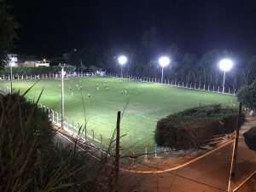

In [ ]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images('campo de futebol bom', max_images=10)[8], 'good-pitch.jpg', show_progress=False)
Image.open('good-pitch.jpg').to_thumb(256,256)

Searching for 'campo de futebol ruim'


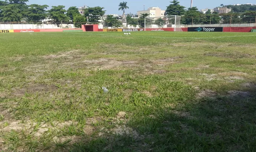

In [ ]:
download_url(search_images('campo de futebol ruim', max_images=1)[0], 'bad-pitch.jpg', show_progress=False)
Image.open('bad-pitch.jpg').to_thumb(256,256)

Agora que nossa pesquisa apresentou resultados coerentes, vamos baixar diversos exemplos e colocá-los em uma pasta.

In [ ]:
labels = 'campo-de-futebol-bom', 'campo-de-futebol-ruim'
path = Path('gramados-de-futebol')

for i in labels:
  dest = (path/i)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'baixando imagem de {i}'))

Searching for 'baixando imagem de campo-de-futebol-bom'
Searching for 'baixando imagem de campo-de-futebol-ruim'


Algumas fotos podem não ter sido baixados corretamente, o que pode causar o nosso modelo a falhar. Portando iremos remove-lás.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print('Imagens Removidas: ')
len(failed)

Imagens Removidas: 


1

Para criar nosso modelo para fazer a predição são necessários os `DataLoaders`, que é um objeto que contém um conjunto de treinamento (imagens usadas para criar um modelo) e um conjunto de validação (imagens usadas para verificar a precisão do modelo)

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

O objetivo DataBlock tem esses parâmetros:

`blocks`: Os nossos inputs são imagens, por isso estamos usando ImageBlocks, e nossos outputs são categorias, no nosso caso (Bom e ruim)

`get-items`: Para encontrar todos os nossos inputs, usamos a função get_image_files.

`splitter`: Aqui estamos dividindo os dados para o treinamento e validação. No nosso caso, 20% dos dados vão ser usados para validação e não serão usados no treinamento.

`get_y`: Isso irá associar cada imagem com o rótulo da pasta em que se encontra, por isso o nome das pastas em que as imagens se encontram devem ser significativos.

`item_tfms`: Isso irá redimensionar as imagens para 192px, utilizando o método de 'squish'

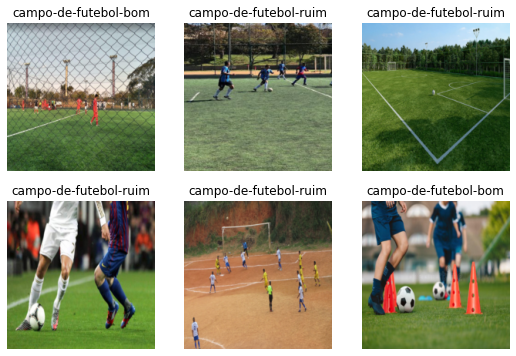

In [ ]:
dls.show_batch(max_n=6)

Abaixo treinaremos o modelo utilizando a função 'vision_learner', na qual a 'restnet18' é a rede neural convolucional utilizada. Logo após utilizamos o 'fine_tune', que utiliza modelos pré-treinados para melhorar o modelo já criado.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.502606,4.333107,0.523810,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.958165,2.727515,0.523810,00:19
1,0.693481,2.061910,0.476190,00:20
2,0.577720,0.519260,0.238095,00:20
3,0.442445,0.084615,0.000000,00:20
4,0.351063,0.030327,0.000000,00:19


Agora vamos testar o modelo depois do treinamento.

Isso é: campo-de-futebol-ruim.


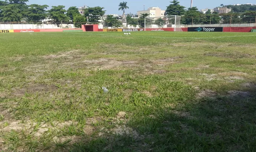

In [ ]:
is_good,_,probs = learn.predict(PILImage.create('bad-pitch.jpg'))
print(f"Isso é: {is_good}.")

Image.open('bad-pitch.jpg').to_thumb(256,256)